In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dense,
                                     Dropout, GlobalAveragePooling2D, BatchNormalization,
                                     Activation, Multiply, Reshape, SpatialDropout2D)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import os
from PIL import Image

2025-04-16 21:18:45.917496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744838326.209026      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744838326.294487      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Augmentation + Split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=(0.7, 1.3),
    channel_shift_range=20,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dog-and-cat-classification-dataset/PetImages/',
    target_size=(224, 224),
    # batch_size=32,
    class_mode='binary',
    subset='training'  # 80% for training
)

val_generator = train_datagen.flow_from_directory(
    '/kaggle/input/dog-and-cat-classification-dataset/PetImages/',
    target_size=(224, 224),
    # batch_size=32,
    class_mode='binary',
    subset='validation'  # 20% for validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/cat-dog/',
    target_size=(224, 224),
    # batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [3]:
train_generator

In [4]:
val_generator

In [5]:
test_generator

In [6]:
# SE Block Function
def se_block(input_tensor, ratio=8):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

# Functional API Model Definition
inputs = Input(shape=(224, 224, 3))
x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.3)(x)

x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = SpatialDropout2D(0.4)(x)

x = Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Add SE Block
x = se_block(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

I0000 00:00:1744838360.003610      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744838360.004255      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
# Compile
model.compile(optimizer=Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 224, 224, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 128)  │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 112, 112, 128)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 256)    │          1,024 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 256)    │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ spatial_dropout2d         │ (None, 28, 28, 256)    │              0 │ max_pooling2d_2[0][0]  │
│ (SpatialDropout2D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 512)    │      1,180,160 │ spatial_dropout2d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 28, 28, 512)    │          2,048 │ conv2d_3[0][0]         │
│ (BatchNormalization) 

 Total params: 4,114,369 (15.70 MB)

 Trainable params: 4,111,425 (15.68 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [9]:
# Training
history = model.fit(
    train_generator,
    # steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    # validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=30
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744838374.389401      84 service.cc:148] XLA service 0x7fc1d0209420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744838374.390483      84 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744838374.390510      84 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744838375.266638      84 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/625 ━━━━━━━━━━━━━━━━━━━━ 4:55:56 28s/step - accuracy: 0.5625 - loss: 0.8198

I0000 00:00:1744838391.204545      84 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


418/625 ━━━━━━━━━━━━━━━━━━━━ 1:54 552ms/step - accuracy: 0.5771 - loss: 0.7891

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 458s 689ms/step - accuracy: 0.5846 - loss: 0.7839 - val_accuracy: 0.5910 - val_loss: 0.7682
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 338s 536ms/step - accuracy: 0.6349 - loss: 0.7444 - val_accuracy: 0.6004 - val_loss: 0.7831
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 337s 534ms/step - accuracy: 0.6622 - loss: 0.7244 - val_accuracy: 0.6881 - val_loss: 0.6905
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 333s 528ms/step - accuracy: 0.6812 - loss: 0.7031 - val_accuracy: 0.6969 - val_loss: 0.6661
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 335s 532ms/step - accuracy: 0.6948 - loss: 0.6815 - val_accuracy: 0.6753 - val_loss: 0.7199
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 335s 530ms/step - accuracy: 0.7036 - loss: 0.6674 - val_accuracy: 0.7433 - val_loss: 0.6265
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 334s 529ms/step - accuracy: 0.7082 - loss: 0.6517 - val_accuracy: 0.7391 - val_loss: 0.6222
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 335s 531ms/step - accuracy: 0.7198 - loss: 0.63

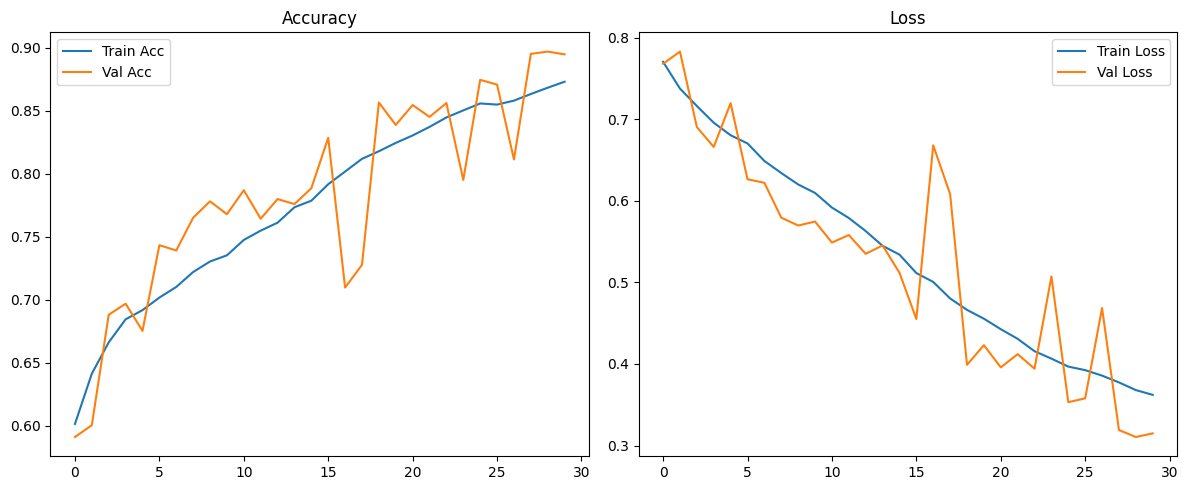

In [10]:
# Plotting
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.tight_layout()
plt.show()

In [11]:
# Evaluate on test data
loss, acc = model.evaluate(test_generator)
print(f"Test accuracy: {acc:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.9032 - loss: 0.3086
Test accuracy: 0.9237


In [12]:
#folder_path = '/kaggle/input/dog-and-cat-classification-dataset/PetImages'
#extensions = []
#for fldr in os.listdir(folder_path):
#    sub_folder_path = os.path.join(folder_path, fldr)
#    for filee in os.listdir(sub_folder_path):
#        file_path = os.path.join(sub_folder_path, filee)
#        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
#        im = Image.open(file_path)
#        rgb_im = im.convert('RGB')
#        if filee.split('.')[1] not in extensions:
#            extensions.append(filee.split('.')[1])

In [13]:
#folder_path = '/kaggle/input/cat-dog'
#extensions = []
#for fldr in os.listdir(folder_path):
#    sub_folder_path = os.path.join(folder_path, fldr)
#    for filee in os.listdir(sub_folder_path):
#        file_path = os.path.join(sub_folder_path, filee)
#       print('** Path: {}  **'.format(file_path), end="\r", flush=True)
#        im = Image.open(file_path)
#        rgb_im = im.convert('RGB')
#        if filee.split('.')[1] not in extensions:
#            extensions.append(filee.split('.')[1])

In [14]:
model.save('VGGLike_model.h5')